**Citation: https://chat.openai.com/**

In [168]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [169]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [170]:
!rm -rf '/content/drive/My Drive/lfw/__MACOSX'

In [171]:
path = '/content/drive/My Drive/lfw'

In [172]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [173]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


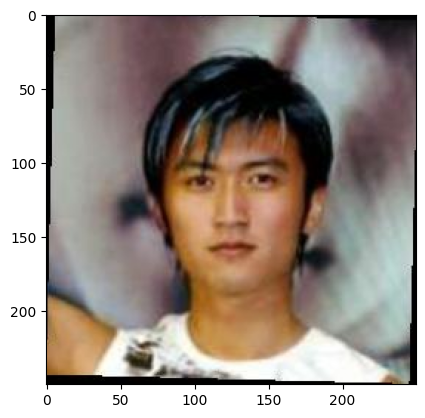

In [174]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

**Differences Between AutoEncoders and Variational AutoEncoders (VAEs**)

**Applications:**

*AutoEncoders (AE):*

Consider AutoEncoders (AEs) as the data wizards that simplify and enhance data. They are your first choice for tasks like simplifying difficult information, picking up crucial aspects, and de-noising data. When the goal is to provide intelligent, effective snapshots of your data, they perform at their best.

*Variational AutoEncoders (VAE):*

This is what you would imagine if you were a data artist. While VAEs possess the same abilities as AEs, they are more artistically inclined. Imagine creating completely new data that appears to be a member of your current data family. Ideal for creating pictures, identifying peculiarities, and occasionally even writing paragraphs.

**Architecture:**

*AE:*  Introducing the encoder and decoder team. Your input is compressed by the encoder into a little, compact package called the latent space, which the decoder then unpacks to restore it to its original form. It resembles an easy journey with no shocks. In AE, the latent space resembles a straight route with no turns or bends.

*VAE:* The artist who enjoys a little unpredictability is known as the VAE. It features an encoder and decoder exactly like AE, but here's the twist: the encoder paints a cloud of options rather than just choosing the path. A distribution, usually Gaussian, turns the latent space into an array of possibilities. Because of this element of chance, VAEs are ideal for producing rather unusual items.

**Loss Function:**

*AE:*

The key factor in AE land is how closely the decoded version resembles the original. Consider it like comparing the recipe to a freshly cooked cake; it should work. Often, Binary Cross-Entropy (BCE) or Mean Squared Error (MSE) are the preferred tools for this kind of comparison.

*VAE:*
The loss function gains a two-part harmony from the VAE. It first determines whether the input and its replication (such as AE) are similar. The KL Divergence is a special addition after that. This section makes sure that the encoder's chosen path fits into a known distribution, which is typically a standard normal. It's like giving the creative chaos a little bit of order by directing the artist to adhere to a particular style.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [175]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Define layers for the encoder
        self.enc_fc1 = nn.Linear(4096, 1024)
        self.enc_fc_mu = nn.Linear(1024, 50)
        self.enc_fc_logvar = nn.Linear(1024, 50)

        # Define layers for the decoder
        self.dec_fc1 = nn.Linear(50, 1024)
        self.dec_fc2 = nn.Linear(1024, 4096)

    def encoder(self, x):
        h = F.relu(self.enc_fc1(x))
        return self.enc_fc_mu(h), self.enc_fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = F.relu(self.dec_fc1(z))
        return torch.sigmoid(self.dec_fc2(h))

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 4096))  # Adjust the view for your input size
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [176]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, inside_feature, hddn_feature, ltnt_feature):
        super(VAE, self).__init__()
        # layers for encoder
        self.enc_fc1 = nn.Linear(inside_feature, hddn_feature)
        self.enc_fc_mu = nn.Linear(hddn_feature, ltnt_feature)
        self.enc_fc_logvar = nn.Linear(hddn_feature, ltnt_feature)
        # layers for decoder
        self.dec_fc1 = nn.Linear(ltnt_feature, hddn_feature)
        self.dec_fc2 = nn.Linear(hddn_feature, inside_feature)

    def encode(self, x):
        h = F.relu(self.enc_fc1(x))
        return self.enc_fc_mu(h), self.enc_fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.dec_fc1(z))
        return torch.sigmoid(self.dec_fc2(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, inside_feature))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Defining the dimensions
inside_feature = 64 * 64
hddn_feature = 512
ltnt_feature = 50

# Instantiate the VAE
model = VAE(inside_feature, hddn_feature, ltnt_feature)

# simulated image created for deomstration
sim_img = torch.randn(1, inside_feature)  # Single image

# Passing the simulated images through vae
reconstruct, mu, logvar = model(sim_img)

# Printing all the shape of the out so it will aslo confirm forward pass
print("mu shape is:", mu.shape)
print("logvar shape is:", logvar.shape)
print("reconstruct image shape is:", reconstruct.shape)

# created new sample
z_new_sample = model.reparameterize(mu, logvar)

# Using decoder to generate new image
new_reconstruct_image = model.decode(z_new_sample)

# Printing the shape of new reconstruct image
print("New reconstruct image shape is: ", new_reconstruct_image.shape)


mu shape is: torch.Size([1, 50])
logvar shape is: torch.Size([1, 50])
reconstruct image shape is: torch.Size([1, 4096])
New reconstruct image shape is:  torch.Size([1, 4096])


**Explanation: Generating New Samples in the Latent Space:**

**To generate new samples in the latent space, we use the learned distributions (mean mu and log variance logvar) of the latent space. Here's the conceptual process:**

**Sampling from the Latent Space:** The VAE gains the ability to probabilistically represent input data in a latent space. The encoder returns a distribution (mean and log variance) in this space for each input.

**Reparameterization Trick:** Using the reparameterization approach (mu + eps * std), we sample from this distribution such that the model can backpropagate through stochastic nodes.

**Generating New Data:** We can create new data samples that closely resemble the original data distribution by sampling various locations in this latent space (either from the distributions provided by the encoder or from a conventional normal distribution) and feeding them through the decoder.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optim for training

In [177]:
total_params = sum(p.numel() for p in model.parameters())
print("total parameters will be: ", total_params)


total parameters will be:  4276324


In [178]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)


**Explaining the Loss Function for a VAE:**

The reconstruction loss and the KL divergence are the two separate notes that make up the loss function in the context of variational autoencoders (VAEs).

**Reconstruction Loss:** Consider Reconstruction Loss as the VAE's attempt to reconstruct a work of art. The degree to which the decoder can replicate the original input is measured. Consider Mean Squared Error (MSE) as a measure of continuous data and Binary Cross-Entropy (BCE) as a measure of binary data. These metrics allow one to assess the similarity between the original and replicated components.

**MSE:** Calculating the average of the squared deviations between the reconstruct and original pictures is similar to a judge grading a decoder's effort.

**BCE:** Visualize this as a probabilistic landscape navigation assessment of how well the output distribution matches the desired distribution.

**KL Divergence:** Let's now explore the enigmatic world of KL Divergence. The detective's task is to determine how far the hidden world of the VAE (represented by mu and logvar) deviates from the predicted norm, which is a conventional normal distribution with a mean of 0 and a variance of 1. This exploratory effort guarantees that the latent space has desired properties, such as completeness and smooth transitions, which are essential for producing new samples that capture the essence of the original data.

**Goal of KL Divergence:** The purpose of KL Divergence is to function as a guardian, keeping the learned latent variable distribution from deviating too much from the predicted norm. This guardianship ensures a robust generating process by warding off the threat of overfitting.

These two sections together make up the entire composition of this symphony of loss. The tricky dance is striking the correct balance: if you focus too much on KL divergence, the quality of the restored masterwork may suffer; if you place too much attention on reconstruction loss, the latent world may disappear into obscurity. Maintaining this careful balance is necessary to make sure the VAE creates an engaging story about creation and rebuilding.

In [179]:
def model_loss(reconstruct_x, x, mu, logvar):
    # loss of reconstruction
    recon_loss = F.binary_cross_entropy(reconstruct_x, x, reduction='sum')

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    ttl_loss = recon_loss + kl_div
    return ttl_loss


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [180]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(inside_feature))
])

dataset = ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [182]:
# Number of epochs to train the model
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in dataloader:
        images = images.view(-1, 4096)

        # Forward pass
        reconstructed_images, mu, logvar = model(images)

        # Calculate loss
        loss = model_loss(reconstructed_images, images, mu, logvar)

        # Backward pass and optimize
        optim.zero_grad()  # Zero the gradients
        loss.backward()        # Calculate gradients
        optim.step()       # Update parameters

        total_loss += loss.item()

    # Calculate average loss over the epoch
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 2563.8126
Epoch [2/20], Loss: 2434.7833
Epoch [3/20], Loss: 2373.7149
Epoch [4/20], Loss: 2340.7598
Epoch [5/20], Loss: 2316.1841
Epoch [6/20], Loss: 2298.1372
Epoch [7/20], Loss: 2284.9743
Epoch [8/20], Loss: 2276.4192
Epoch [9/20], Loss: 2265.4872
Epoch [10/20], Loss: 2258.9310
Epoch [11/20], Loss: 2252.8905
Epoch [12/20], Loss: 2247.8254
Epoch [13/20], Loss: 2243.0913
Epoch [14/20], Loss: 2238.6033
Epoch [15/20], Loss: 2235.6026
Epoch [16/20], Loss: 2233.2300
Epoch [17/20], Loss: 2229.1472
Epoch [18/20], Loss: 2226.6752
Epoch [19/20], Loss: 2223.6745
Epoch [20/20], Loss: 2222.0584


**Troubleshooting Non-Decreasing Loss**

If the loss is not decreasing, here are some steps to troubleshoot:

**Learning Rate:** Visualize the learning rate as the learning model's volume control. Try gently reducing the volume if it's too loud; sometimes, subtlety is the key.

**Model Architecture:** Treat your model like a chef by providing it with the necessary equipment. Verify that the architecture of your model corresponds with the intricacy of your data. Similar to how a soup pot is not meant to be used with a teaspoon, the model requires the proper configuration.

**Overfitting/Underfitting:** Evaluate if the model is overfitting or underfitting. Overfitting might require more regularization; underfitting might need a more complex model or longer training.

**Data Preprocessing:** Verify that the necessary measures for data preprocessing (such as proper normalization) have been taken.

**Loss Function:** Check that the loss function implementation is accurate.
Batch Size: Test out various batch sizes. Updates occur more frequently with smaller batch sizes.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

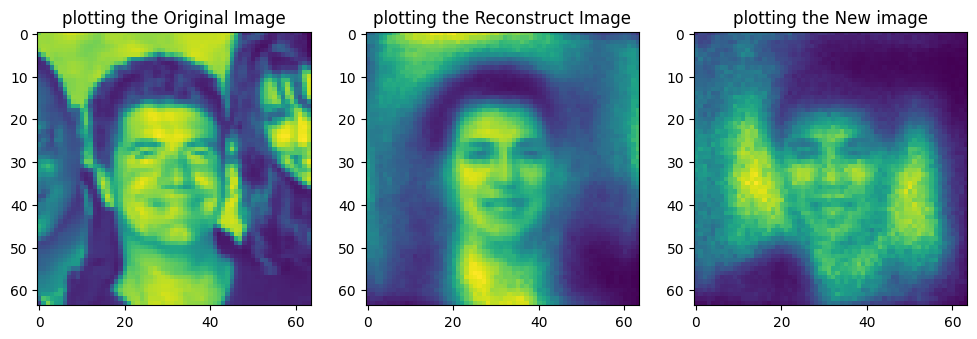

In [194]:
import matplotlib.pyplot as plt
import torch

# Fetching a random image
original_images, _ = next(iter(dataloader))
original_image = original_images[0]  # Taking the first image

# Preparing a images
original_image_model = original_image.view(-1, inside_feature)

# doing forward pass
reconstruct, _, _ = model(original_image_model)

# Generating a new sample
random_mu = torch.randn_like(mu[0])  # Random mu
random_logvar = torch.randn_like(logvar[0])  # Random logvar
new_sample = model.reparameterize(random_mu, random_logvar)
new_reconstruct_image = model.decode(new_sample).view(64, 64)  # Reshape back to 64x64

# Reshaping the orignal and reconstruct images
original_image_np = original_image.view(64, 64).detach().numpy()
reconstruct_image_np = reconstruct.view(64, 64).detach().numpy()
new_reconstruct_image_np = new_reconstruct_image.detach().numpy()

# Plotting all the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("plotting the Original Image")
plt.imshow(original_image_np)
plt.subplot(1, 3, 2)
plt.title("plotting the Reconstruct Image")
plt.imshow(reconstruct_image_np)
plt.subplot(1, 3, 3)
plt.title("plotting the New image")
plt.imshow(new_reconstruct_image_np)
plt.show()
